# Modeling
---
In this notebook we are running a Logsitic Regression model on our data. We are dropping columns that are not significant predictors by using an F-Regression method. 

In [107]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, accuracy_score, f1_score, roc_auc_score, plot_precision_recall_curve, plot_roc_curve 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_regression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

In [108]:
df = pd.read_csv('Data/model_df.csv')
df.dropna(axis = 1, inplace = True) 
df['stay_calm_2'] = df['stay_calm']**2
df['bullied_2'] = df['BULLIED_R']**2
df['gen_health_2'] = df['gen_health']**2
df['school_prob_2'] = df['school_prob']**2
df['HCABILITY_2'] = df['HCABILITY']**2

X = df.drop(columns = ['depression' ,'anxiety', 'dep_anx_hist']) # target cols
y = df['dep_anx_hist'] # target col

In [109]:
# perform f_regression on features to remove low significance features
drop_cols = pd.DataFrame(zip(X.columns, f_regression(X, y)[1])).sort_values(by = 1, ascending = False)[:60][0].values

model_X = X.drop(columns = drop_cols)

analysis_X = X.drop(columns = drop_cols)

# Imbalanced Data
The undersampler worked best with our data. SMOTE introduced too much noise, and oversampling changed the variance of our patient population too much. 

----

In [19]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(model_X, y, stratify = y, test_size = .3)

# under sample
und = RandomUnderSampler()
X_train_under, y_train_under = und.fit_resample(X_train, y_train)

# Logistic Regression
I created a GridSearch pipeline to solve for the best values of C and the L1 Ratio in the elasticnet model. I used recall, f1-score, and roc-auc score as scoring metrics for the GridSearch until I optimized recall without compromising precision too much. I chose to optimize recall since comparatively, the proportion of miscalssified "healthy" adolescents is very small to the actual non-patient population. Optimistically, these individuals could have been misclassified since they are "at risk" for developing depression and anxiety. Most people that have these disorders develop them in their adolescence, but not always. The goal is to find factors that predict Depression and Anxiety, not to diagnose people. 

In [64]:
# pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(max_iter = 5_000))
])

pipe_params = {
    'ss__with_mean'     : [True],
    'ss__with_std'      : [True],
    'lr__penalty'      : ['elasticnet'],
    'lr__C'            : np.linspace(.01, .023, 20),
    'lr__solver'       : ['saga'],
    'lr__l1_ratio'     : [0]
}

# gridsearch
gs = GridSearchCV(pipe, pipe_params, cv = 3, verbose = 1, scoring = 'recall', return_train_score=True)

# fit model
gs.fit(X_train_under, y_train_under)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(max_iter=5000))]),
             param_grid={'lr__C': array([0.01      , 0.01068421, 0.01136842, 0.01205263, 0.01273684,
       0.01342105, 0.01410526, 0.01478947, 0.01547368, 0.01615789,
       0.01684211, 0.01752632, 0.01821053, 0.01889474, 0.01957895,
       0.02026316, 0.02094737, 0.02163158, 0.02231579, 0.023     ]),
                         'lr__l1_ratio': [0], 'lr__penalty': ['elasticnet'],
                         'lr__solver': ['saga'], 'ss__with_mean': [True],
                         'ss__with_std': [True]},
             return_train_score=True, scoring='recall', verbose=1)

In [65]:
gs.best_params_

{'lr__C': 0.020263157894736844,
 'lr__l1_ratio': 0,
 'lr__penalty': 'elasticnet',
 'lr__solver': 'saga',
 'ss__with_mean': True,
 'ss__with_std': True}

TRAIN ACC: 0.8283333333333334
TEST ACC: 0.8626373626373627

TRAIN PREC: 0.8648148148148148
TEST PREC: 0.6020408163265306

TRAIN RECALL: 0.7783333333333333
TEST RECALL: 0.8019417475728156

TRAIN ROC-AUC: 0.8283333333333333
TEST ROC-AUC: 0.8393455916193648


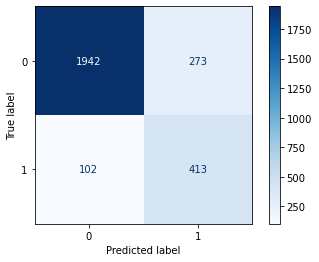

In [66]:
# scale data
ss = StandardScaler(with_mean=True, with_std=True)
X_train_under = ss.fit_transform(X_train_under)
X_test = ss.transform(X_test)

# fit model
lr = LogisticRegression(C = 0.020263157894736844, l1_ratio =  0, penalty = 'elasticnet', solver = 'saga', max_iter = 10_000)
lr.fit(X_train_under, y_train_under)

# print metrics
print('TRAIN ACC:', lr.score(X_train_under, y_train_under))
print('TEST ACC:', lr.score(X_test, y_test))
print()
print('TRAIN PREC:', precision_score(y_train_under, lr.predict(X_train_under)))
print('TEST PREC:', precision_score(y_test, lr.predict(X_test)))
print()
print('TRAIN RECALL:', recall_score(y_train_under, lr.predict(X_train_under)))
print('TEST RECALL:', recall_score(y_test, lr.predict(X_test)))
print()
print('TRAIN ROC-AUC:', roc_auc_score(y_train_under, lr.predict(X_train_under)))
print('TEST ROC-AUC:', roc_auc_score(y_test, lr.predict(X_test)))
plot_confusion_matrix(lr, X_test, y_test, cmap='Blues');

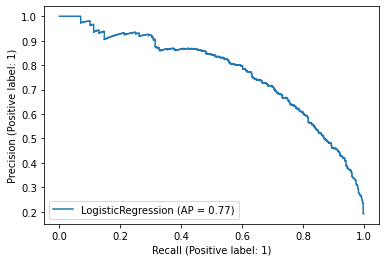

In [86]:
plot_precision_recall_curve(lr, X_test, y_test)

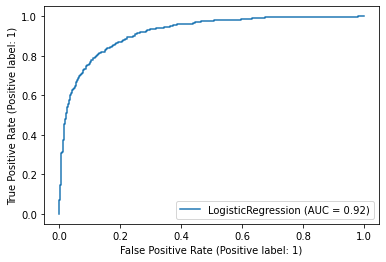

In [87]:
plot_roc_curve(lr, X_test, y_test)

# Visualizing Differences in Key Predictors

In [171]:
def plot_diff(df, target, cols):
    plt.figure(figsize = (30, 20))
    for i, col in enumerate(cols):
        plt.subplot(3, 4, i+1)
        sns.barplot(data = df, x = target, y = col)
        plt.xlabel('History of Dep/Anx')

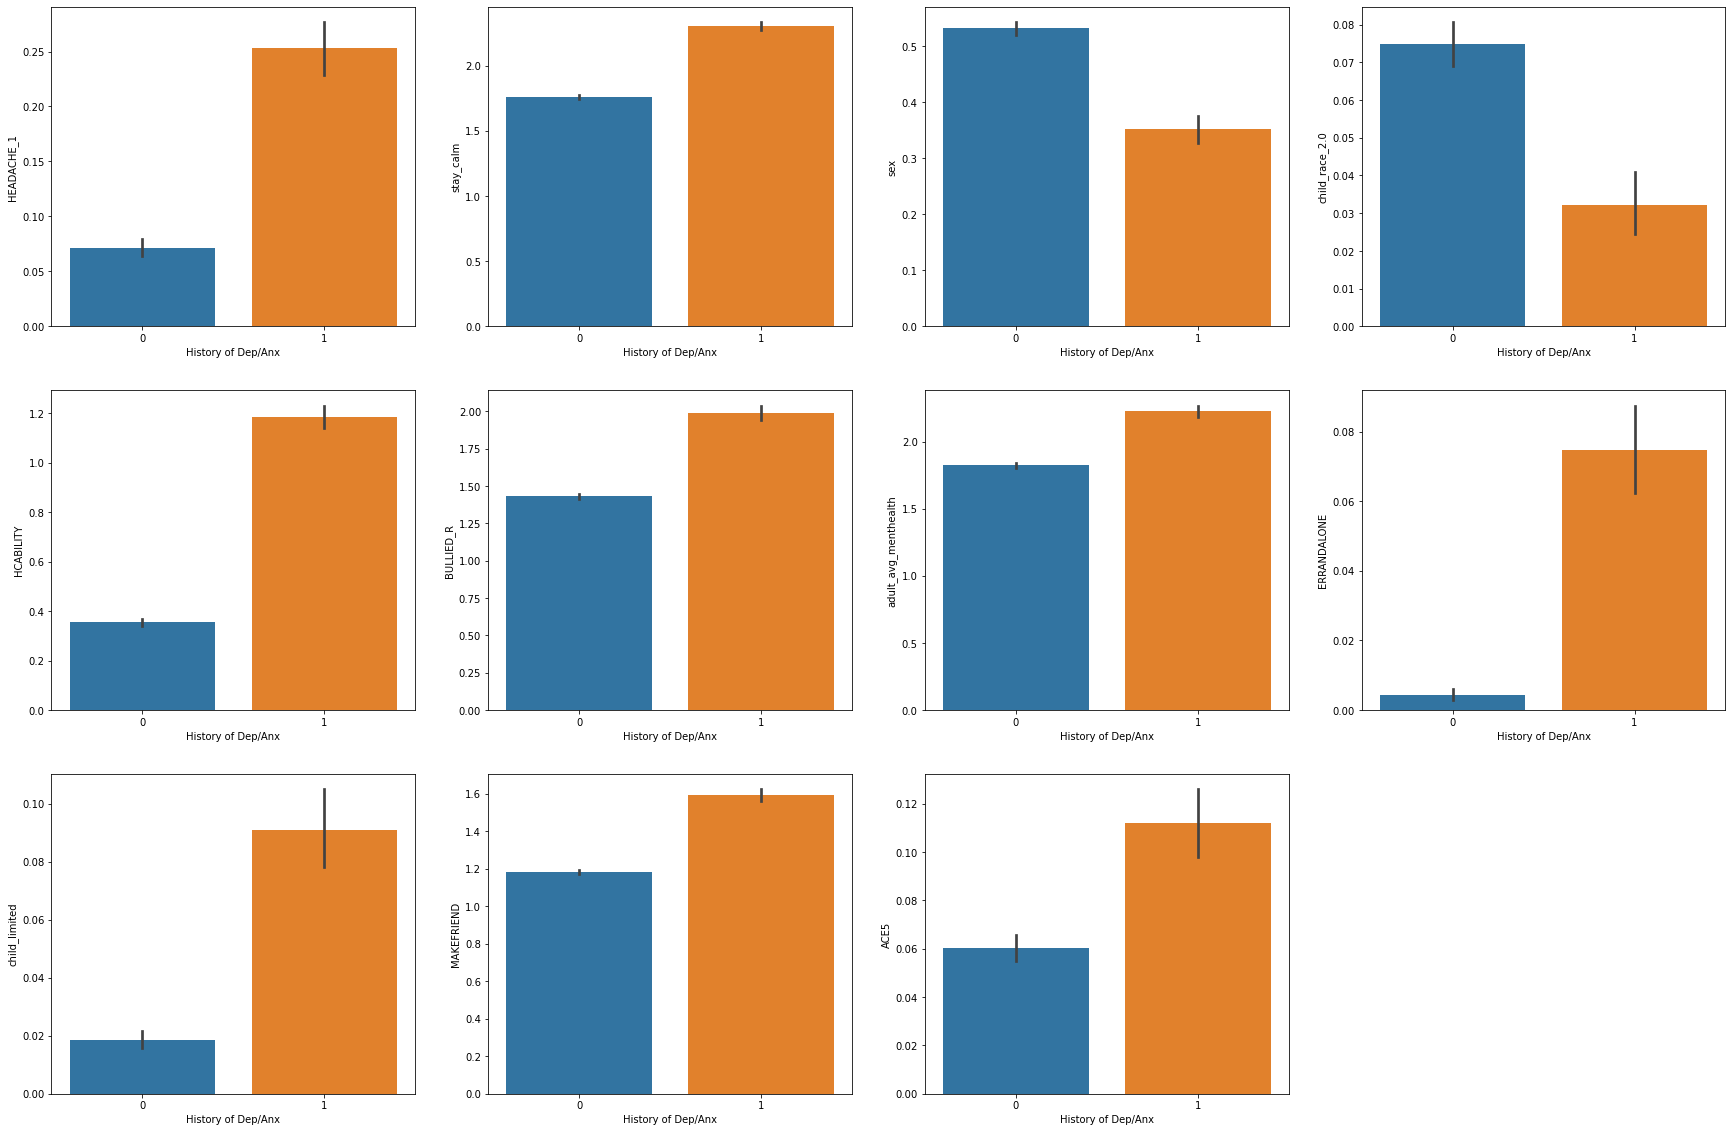

In [172]:
t_test_cols = list(pd.DataFrame(np.abs(lr.coef_[0]), columns = ['beta'], index = model_X.columns).sort_values(by = 'beta', ascending = False)[3:14].index)
plot_diff(df, 'dep_anx_hist', t_test_cols)

# Misclassified Analysis

In [110]:
ss = StandardScaler(with_mean=True, with_std=True)
model_X_sc = ss.fit_transform(model_X)
preds = lr.predict(model_X_sc)
analysis_X['actual'] = y
analysis_X['predicted'] = preds

In [173]:
def plot_miss(df, target, cols, hue):
    plt.figure(figsize = (30, 20))
    for i, col in enumerate(cols):
        plt.subplot(3, 4, i+1)
        sns.barplot(data = df, x = target, y = col, hue = hue, palette = ['navy', 'lightblue'])
        plt.xlabel('History of Dep/Anx')

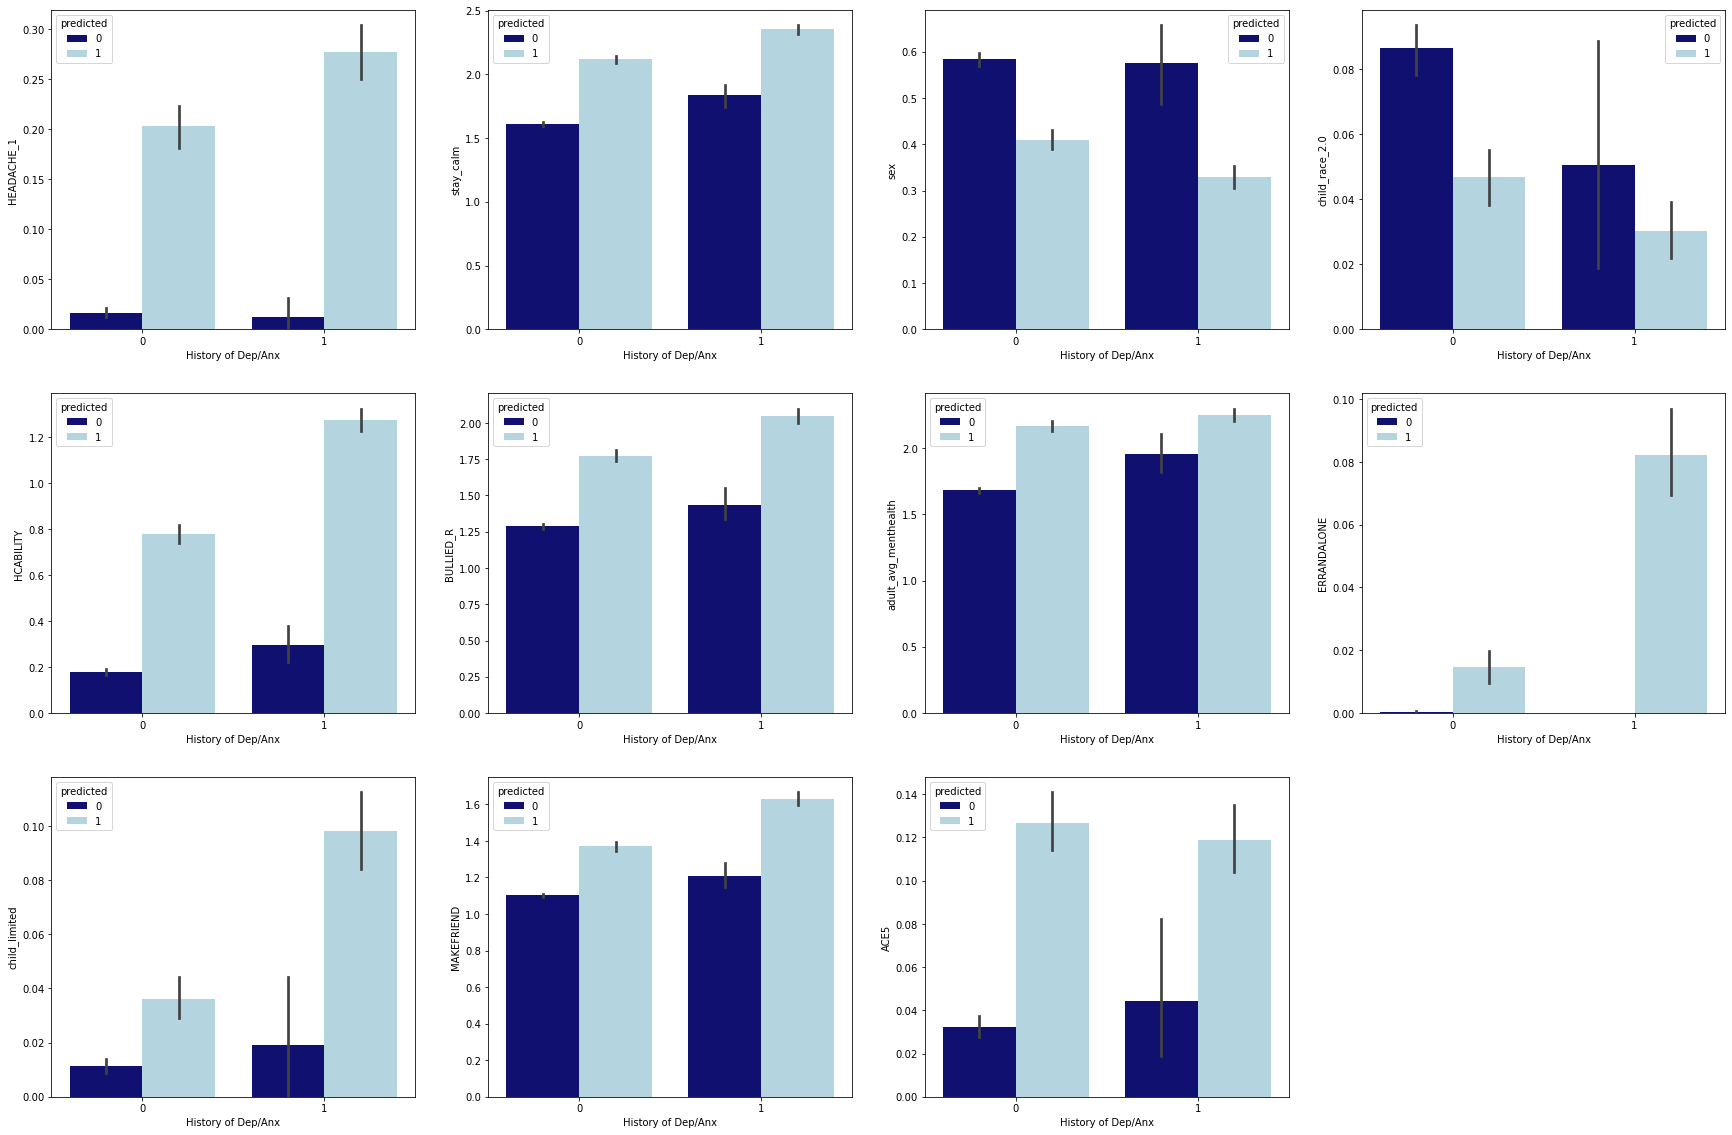

In [174]:
plot_miss(analysis_X, 'actual', t_test_cols, 'predicted')

Now if we break it down by how we predicted them, we can see that those we misclassified resemble the observations of that class we predicted them as. This further shows that these features were good predictors for those who actually had depression or anxiety, and those we misclassified in the data truly look like the observations we classified them as, not necessarily what they reported. this makes me think that the non-patient sample we misclassified as depressed or anxious could be at-risk/vulernable.

# Overall Model Performance

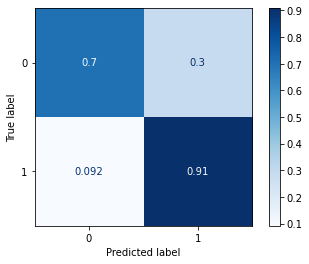

In [153]:
plot_confusion_matrix(lr, model_X_sc, y, normalize = 'true', cmap='Blues');

In [154]:
print('Accuracy:', lr.score(model_X_sc, y))
print()
print('Precision:', precision_score(y, preds))
print()
print('Recall:', recall_score(y, preds))
print()
print('ROC/AUC:', roc_auc_score(y, preds))

Accuracy: 0.7431021215785424

Precision: 0.4167558886509636

Recall: 0.9078717201166181

ROC/AUC: 0.8063471307166672


Looking at how the model performed on our full data set, we got .91 recall, .42 precision, and and roc/auc score of .81

It is important here to remember our goal and our data. We had non-symptom data, so it makes sense that we didn't have the best model ever to predict adolescent dep/anx. Due to the class imbalance, it's okay if we don't have perfect precision because the number of these observations in comparison to our "healthy" population is really small. Additionally, these observations could represent those 'at-risk' of developing dep/anx. Our model was supposed to learn the features that best predicted depression and anxiety, so optimizing for recall makes sense in this context. 

# Conclusions

Our goal was to highlight factors that could be targets for future research and interventions. <br>

In terms of the usefulness of the NSCH19 in determining these factors, some of the model metrics could be alarming, but I think the best use case for this project is showing factors that could inspire other experimental research to more accurately measure effect size on dep/anx symptoms in youth. our model did account for age, but this would also be a variable that could benefit from other information such as pubertal data, and other cognitive functions. 

Some improvements could be using past NSCH to increase the amount of data in our model - not all of the surveys are identical but it is possible to combine. we could also spend more time on feature selection and feature engineering. the technqiues I used greatly improved the model, but more could definitely be done, and finally the imputation method could be examined to see it's effect on the model. I used a KNN Imputer, but there are many other methods that could be examined. 

In summary, I would recommend that the NSCH adds some Depression/Anxiety symptom questions to better analyze our target, and build out more specific questions related to our top predictive factors

Additionally i would recommend further experimental research into the impact of the non-symptom factors we found. 

Finally, I would also recommend research targeted at interventions on these factors, for example a bullying awareness program in schools. big believer in intervention programs and research - can actually help people and not just "science for science's sake".